In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Google Foto/dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import keras
import keras.backend as K
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/tmp/dataset/train/',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_set = validation_datagen.flow_from_directory('/tmp/dataset/validation/',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/tmp/dataset/test/',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1336 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 376 images belonging to 2 classes.


In [ ]:
densenet = DenseNet201(input_shape=(299,299,3), weights='imagenet', include_top=False)

for layer in densenet.layers:
  layer.trainable = False
x = Flatten()(densenet.output)
prediction = Dense(2, activation='sigmoid')(x)

74850304/74836368 [==============================] - 4s 0us/step


In [ ]:
densenet = Model(inputs=densenet.input, outputs=prediction)

densenet.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
densenet_history = densenet.fit(x= training_set, epochs= 50, validation_data= validation_set)

Epoch 1/50
42/42 [==============================] - 49s 854ms/step - loss: 1.9714 - accuracy: 0.7088 - val_loss: 0.9948 - val_accuracy: 0.7812
Epoch 2/50
42/42 [==============================] - 30s 705ms/step - loss: 0.3042 - accuracy: 0.9117 - val_loss: 0.5461 - val_accuracy: 0.8438
Epoch 3/50
42/42 [==============================] - 30s 703ms/step - loss: 0.2613 - accuracy: 0.9296 - val_loss: 0.6959 - val_accuracy: 0.8490
Epoch 4/50
42/42 [==============================] - 30s 702ms/step - loss: 0.1767 - accuracy: 0.9521 - val_loss: 0.6742 - val_accuracy: 0.8229
Epoch 5/50
42/42 [==============================] - 31s 727ms/step - loss: 0.1361 - accuracy: 0.9573 - val_loss: 0.5094 - val_accuracy: 0.8698
Epoch 6/50
42/42 [==============================] - 30s 703ms/step - loss: 0.1439 - accuracy: 0.9558 - val_loss: 0.8719 - val_accuracy: 0.7969
Epoch 7/50
42/42 [==============================] - 30s 704ms/step - loss: 0.1454 - accuracy: 0.9596 - val_loss: 0.6532 - val_accuracy: 0.8333

In [ ]:
import os
path = "/tmp/dataset/test/"

value = 0
true_classes = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  if(filename == "negative"):
    value = 0
  elif(filename == "pozitive"):
    value = 1
  for img in os.listdir(new_path):
    true_classes.append(value)

In [ ]:
densenet_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (299, 299))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255. 
    result = densenet.predict(test_image)
    densenet_preds.append(np.argmax(result[0]))

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

class_labels = list(test_set.class_indices.keys())
report = classification_report(true_classes, densenet_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    negative       0.85      0.95      0.90       200
    pozitive       0.94      0.81      0.87       176

    accuracy                           0.89       376
   macro avg       0.89      0.88      0.88       376
weighted avg       0.89      0.89      0.88       376



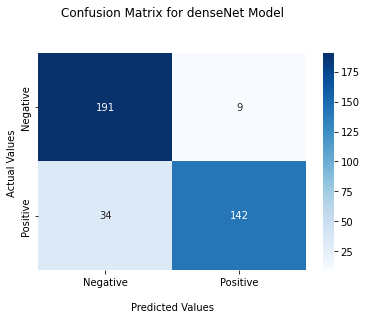

In [ ]:
import seaborn as sns
densenet_confusion = confusion_matrix(true_classes,densenet_preds)

ax = sns.heatmap(densenet_confusion, annot=True, cmap='Blues',fmt='g')


ax.set_title('Confusion Matrix for denseNet Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

plt.show()

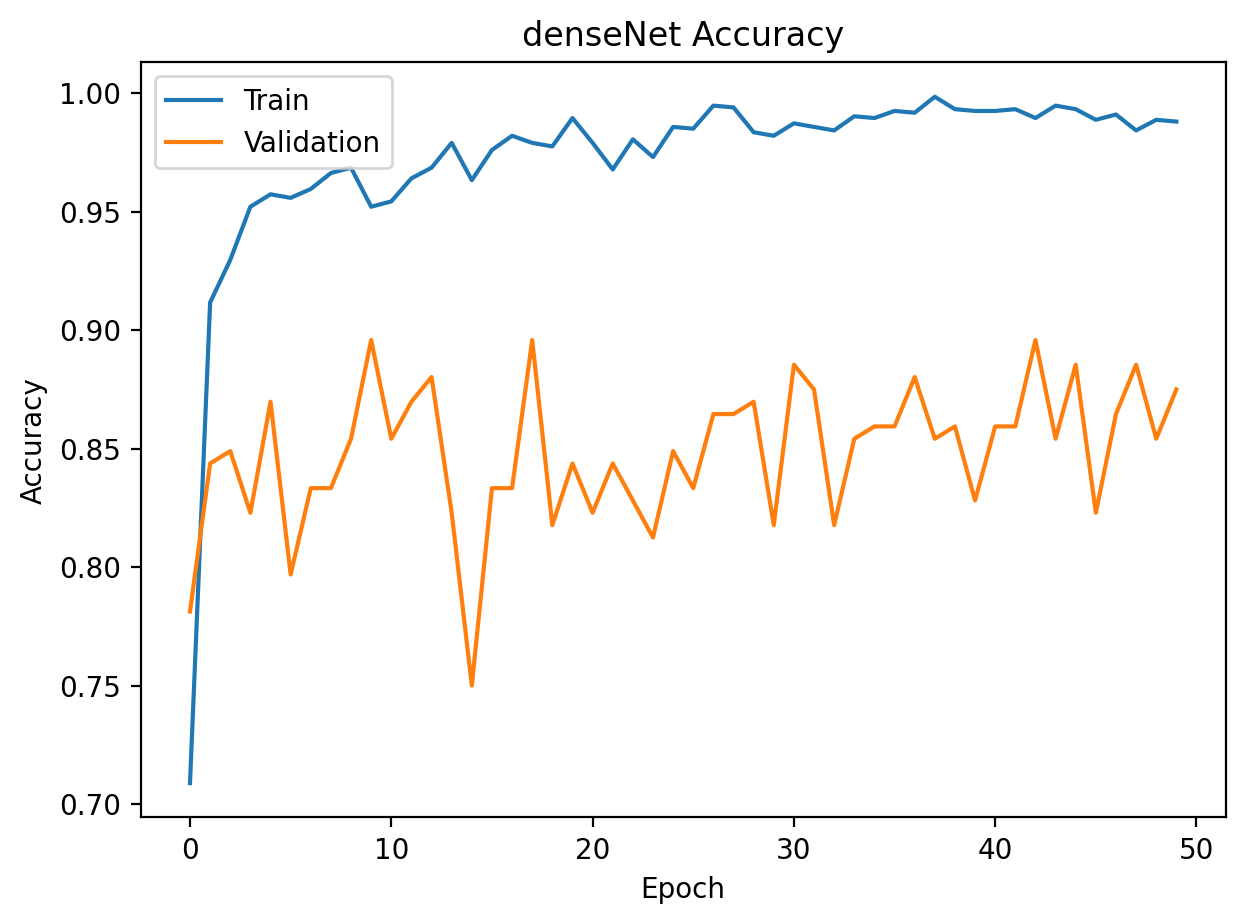

In [ ]:
plt.figure(figsize=(7,5),dpi=200)
plt.plot(densenet_history.history['accuracy'])
plt.plot(densenet_history.history['val_accuracy'])
plt.title('denseNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

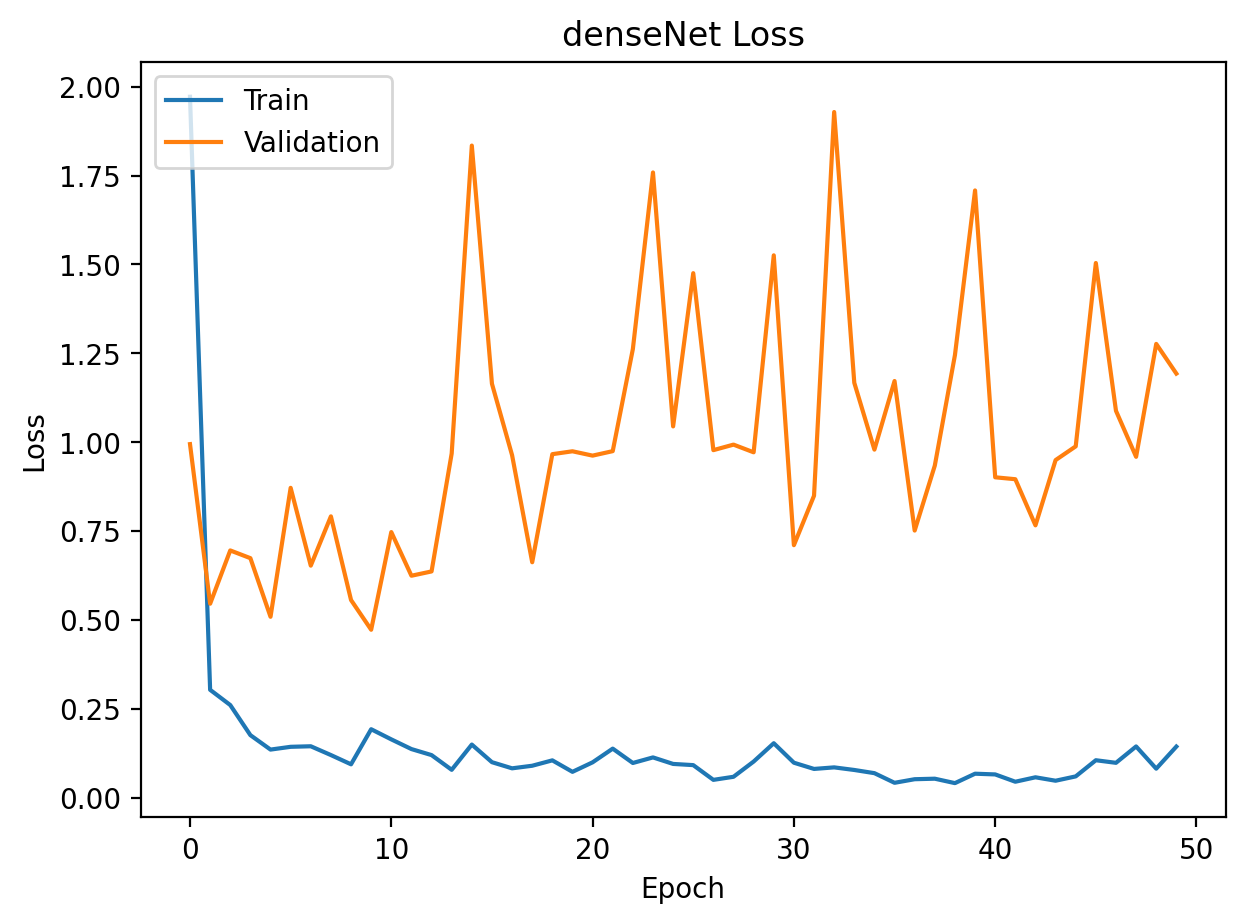

In [ ]:
plt.figure(figsize=(7,5),dpi=200)
plt.plot(densenet_history.history['loss'])
plt.plot(densenet_history.history['val_loss'])
plt.title('denseNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
densenet.save("/content/drive/MyDrive/densenet.h5")